In [1]:
# uodate all libs to latest, otherwise it fails "randomly"
!pip install -Uq fastai
!pip install -Uq fastcore
!pip install -Uq timm
!pip install huggingface_hub -U

In [2]:
!pip install nbdev

In [3]:
import timm

In [4]:
#hide
! [ -e /content ] && pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

In [5]:
#hide
from fastbook import *
from fastai.vision.widgets import *

# From Model to Production

In [6]:
bear_types = 'grizzly','black','teddy'
path = Path('bears')

In [7]:
if not path.exists():
    path.mkdir()
    for o in bear_types:
        dest = (path/o)
        dest.mkdir(exist_ok=True)
        results = search_images_ddg(f'{o} bear')
        download_images(dest, urls=results)
    fns = get_image_files(path)
    print(f"fetched {len(fns)} files")
    failed = verify_images(fns)
    print(f"there are {len(failed)} failed")
    failed.map(Path.unlink);
else:
    print("Skip dataset creation because directory already exists")

Skip dataset creation because directory already exists


# Data volume after extraction

In [8]:
from collections import Counter

In [9]:
Counter(get_image_files(path).map(parent_label))

Counter({'grizzly': 169, 'black': 180, 'teddy': 175})

## From Data to DataLoaders

In [10]:
bears = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=Resize(64))

In [11]:
dls = bears.dataloaders(path, bs=32)

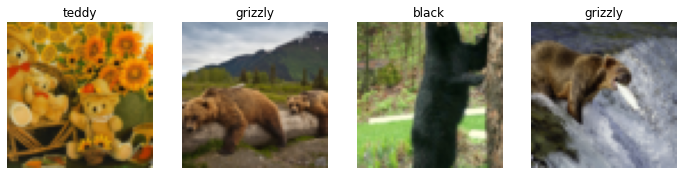

In [12]:
dls.valid.show_batch(max_n=4, nrows=1)

## Training Your Model, and Using It to Clean Your Data

In [13]:
bears = bears.new(item_tfms=RandomResizedCrop(128, min_scale=0.5), batch_tfms=aug_transforms())
dls = bears.dataloaders(path, bs=32)

# Experiment with different kind of models

In [14]:
len(timm.list_models(pretrained=True))

1329

In [15]:
timm.list_models('resnet*', pretrained=True)

['resnet10t.c3_in1k',
 'resnet14t.c3_in1k',
 'resnet18.a1_in1k',
 'resnet18.a2_in1k',
 'resnet18.a3_in1k',
 'resnet18.fb_ssl_yfcc100m_ft_in1k',
 'resnet18.fb_swsl_ig1b_ft_in1k',
 'resnet18.gluon_in1k',
 'resnet18.tv_in1k',
 'resnet18d.ra2_in1k',
 'resnet26.bt_in1k',
 'resnet26d.bt_in1k',
 'resnet26t.ra2_in1k',
 'resnet32ts.ra2_in1k',
 'resnet33ts.ra2_in1k',
 'resnet34.a1_in1k',
 'resnet34.a2_in1k',
 'resnet34.a3_in1k',
 'resnet34.bt_in1k',
 'resnet34.gluon_in1k',
 'resnet34.tv_in1k',
 'resnet34d.ra2_in1k',
 'resnet50.a1_in1k',
 'resnet50.a1h_in1k',
 'resnet50.a2_in1k',
 'resnet50.a3_in1k',
 'resnet50.am_in1k',
 'resnet50.b1k_in1k',
 'resnet50.b2k_in1k',
 'resnet50.bt_in1k',
 'resnet50.c1_in1k',
 'resnet50.c2_in1k',
 'resnet50.d_in1k',
 'resnet50.fb_ssl_yfcc100m_ft_in1k',
 'resnet50.fb_swsl_ig1b_ft_in1k',
 'resnet50.gluon_in1k',
 'resnet50.ra_in1k',
 'resnet50.ram_in1k',
 'resnet50.tv2_in1k',
 'resnet50.tv_in1k',
 'resnet50_gn.a1h_in1k',
 'resnet50c.gluon_in1k',
 'resnet50d.a1_in1k',
 '

In [16]:
learn1 = vision_learner(dls, resnet18, metrics=error_rate)
learn1.fine_tune(5)
metrics1 = learn1.recorder.values
error_rate1 = metrics1[-1][-1]
print("error rate ", error_rate1)

epoch,train_loss,valid_loss,error_rate,time
0,0.971042,0.305881,0.038462,00:13


epoch,train_loss,valid_loss,error_rate,time
0,0.298904,0.283771,0.048077,00:13
1,0.209208,0.276933,0.048077,00:13
2,0.192132,0.348436,0.076923,00:15
3,0.158937,0.291928,0.038462,00:13
4,0.151380,0.279637,0.038462,00:15


error rate  0.03846153989434242


In [36]:
learn2 = vision_learner(dls, 'resnet34.a1_in1k', metrics=error_rate)
learn2.fine_tune(5)
metrics2 = learn2.recorder.values
error_rate2 = metrics2[-1][-1]
print("error rate ", error_rate2)

epoch,train_loss,valid_loss,error_rate,time
0,1.244005,0.172119,0.048077,00:15


epoch,train_loss,valid_loss,error_rate,time
0,0.527578,0.192553,0.057692,00:13
1,0.453060,0.242838,0.067308,00:12
2,0.384701,0.256464,0.076923,00:13
3,0.351434,0.225643,0.086538,00:14
4,0.330869,0.227003,0.076923,00:13


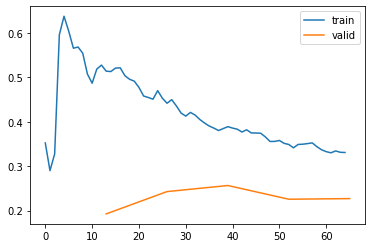

In [37]:
learn2.recorder.plot_loss(skip_start=0, with_valid=True)

In [43]:
interp = ClassificationInterpretation.from_learner(learn2)

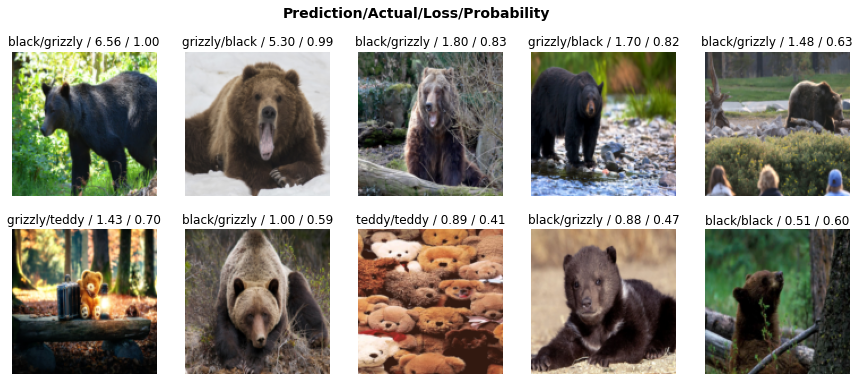

In [45]:
interp.plot_top_losses(10, nrows=2)